## Gaussian Mixtures

In [162]:
import numpy as np

In [163]:
from sklearn.datasets import make_blobs

In [164]:
import matplotlib.pyplot as plt

In [165]:
#make_blobs: generate isotropic Gaussian blobs for clustering.

In [166]:
#make_blobs: n_samples: if int, it is the total number of points equally divided among clusters. 

In [167]:
#make_blobs: n_features (default=2): number of features for each sample.

In [168]:
#make_blobs: centers: number of centers to generate, or the fixed center locations.

In [169]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
#projection on two vectors (column matrices)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))  #dot product of two matrices = matrix multiplication X1*C
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)  #
X2 = X2 + [6, -8]  #translation operation on X2
X = np.r_[X1, X2]  #concatenation: row-wise merging; concatenate along row (first) axis.
#y = np.r_[y1, y2]  #concatenation: row-wise merging; caution label assignment: 3 clusters should have 3 different labels; y2 should be replaced with y2+2.
y = np.r_[y1, y2+2]  #test: 3 clusters with 3 different labels;

###### start: inspect data

##### final dataset

In [170]:
X.shape, y.shape, np.unique(y)

((1250, 2), (1250,), array([0, 1, 2]))

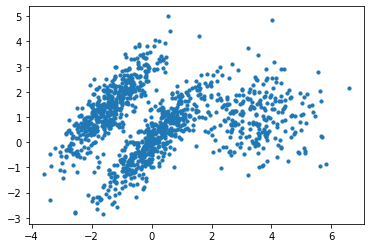

In [171]:
plt.scatter(X[:, 0], X[:, 1], s=10)   #final dataset with three clusters

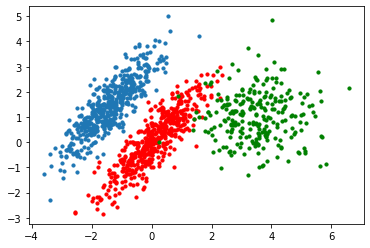

In [172]:
plt.scatter(X[y==0][:, 0], X[y==0][:, 1], s=10)   #final dataset with labels
plt.scatter(X[y==1][:, 0], X[y==1][:, 1], s=10, c='r')   #final dataset with labels
plt.scatter(X[y==2][:, 0], X[y==2][:, 1], s=10, c='g')   #test: final dataset with labels

###### end: inspect data

## train Gaussian mixture model 

In [173]:
from sklearn.mixture import GaussianMixture

In [174]:
#Expectation-Maximization (EM) algorithm: 

In [175]:
#initializes the cluster parameters randomly.
#repeats until convergence:
#  1. expectation step: assigning instances to clusters
#  2. maximization step: updating the clusters

In [176]:
#parameter n_init=10: run several times (10), keeping only the best solution.

In [177]:
gm = GaussianMixture(n_components=3, n_init=10, random_state=42)  #n_components: define 3 clusters
gm.fit(X)

GaussianMixture(n_components=3, n_init=10, random_state=42)

In [178]:
from matplotlib.colors import LogNorm

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]  #consider only centroids with high weights
    plt.scatter(centroids[:, 0], centroids[:, 1],  #coordinates x,y of centroids
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],  #coordinates x,y of centroids
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])  #return -log(p(x)): log(p(x))=negative with p(x)=[0,1]
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,  #contour areas; Z = -log(p(x)) 
                 norm=LogNorm(vmin=1.0, vmax=30.0),  #used to normalize Z to the range of 0-1 on a log scale
                 #norm=LogNorm(vmin=Z.min(), vmax=Z.max()),
                 levels=np.logspace(0, 2, 12))  #draw contour lines at the specified levels; 10**(index*step_size)
    plt.contour(xx, yy, Z,  #contour lines
                norm=LogNorm(vmin=1.0, vmax=30.0),  #used to normalize Z to the range of 0-1 on a log scale
                #norm=LogNorm(vmin=Z.min(), vmax=Z.max()),
                levels=np.logspace(0, 2, 12),  #draw contour lines at the specified levels; 10**(index*step_size)
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])  #hard cluster assignments
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

## Anomaly Detection using Gaussian Mixtures

In [179]:
#Gaussian Mixtures used for anomaly detection: instances located in low-density regions can be considered anomalies. 

In [180]:
#define what density threshold to use; e.g. 4% of the instances located in areas below the threshold density (4).

In [181]:
densities = gm.score_samples(X)  #log(p(x)): p(x)=pdf
density_threshold = np.percentile(densities, 4)  #np.percentile(log[p(x)], 4): q-th percentile of v: value q/100 of the way from the minimum to the maximum in a sorted copy of v. 
anomalies = X[densities < density_threshold]  #x < y <=> exp(x) < exp(y); comparison is invariant to transformation.

In [182]:
#start: diagnose

In [183]:
#test: np.percentile(log[p(x)],4) versus np.percentile(p(x),4)

In [184]:
#test that comparison is invariant to transformation, thus it is save to use np.percentile(log[p(x)],4)

In [185]:
density_threshold_test = np.percentile(np.exp(densities), 4)
anomalies_test = X[np.exp(densities) < density_threshold_test]  #x < y <=> exp(x) < exp(y); comparison is invariant to transformation.

In [186]:
anomalies[:5,:]

array([[-0.11118987,  1.61334992],
       [ 0.62362922,  4.41540435],
       [ 1.49808977, -0.15251688],
       [ 0.74219223, -1.00445177],
       [-2.53940854, -2.76549965]])

In [187]:
anomalies_test[:5,:]

array([[-0.11118987,  1.61334992],
       [ 0.62362922,  4.41540435],
       [ 1.49808977, -0.15251688],
       [ 0.74219223, -1.00445177],
       [-2.53940854, -2.76549965]])

In [188]:
#end: diagnose

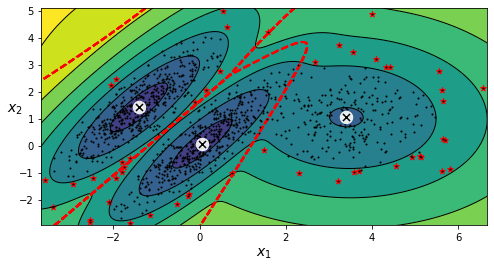

In [189]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')

plt.show()